## Documentation and Summary
- Multivariate input and output: Using x_{1,2,...,T} and y_{1, 2,…, T-1} to predict y_T (4 dimensions to 1 dimension)
- The data is normalized before training and testing
- I have experimented different hyperparameters and the selected values here is: hidden states =20, lstm layer (stacked)= 1, batch size = 16, timestep = 100, learning rate = 0.001
- Outstanding problem:  NA
- Loss function (and also used as metrics here): MSE or MLE



### LSTM

In [1]:
import random
import numpy as np
import torch
import pandas as pd
# multivariate data preparation
from numpy import array
from numpy import hstack


In [2]:
import matplotlib.pyplot as plt

## Data Prepration: Visualize Data and Delete the date column

In [3]:
df = pd.read_csv("/content/bitcoin_yahoo.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-07-16,0.049510,0.049510,0.049510,0.049510,0.049510,0
1,2010-07-17,0.049510,0.085850,0.059410,0.085840,0.085840,5
2,2010-07-18,0.085840,0.093070,0.077230,0.080800,0.080800,49
3,2010-07-19,0.080800,0.081810,0.074260,0.074740,0.074740,20
4,2010-07-20,0.074740,0.079210,0.066340,0.079210,0.079210,42
...,...,...,...,...,...,...,...
3196,2019-04-16,5212.810059,5270.759766,5190.810059,5236.259766,5236.259766,194699629
3197,2019-04-17,5236.259766,5317.779785,5232.990234,5289.750000,5289.750000,187312150
3198,2019-04-18,5289.750000,5353.009766,5212.180176,5295.529785,5295.529785,158699049
3199,2019-04-19,5295.529785,5366.600098,5274.450195,5326.180176,5326.180176,123577001


In [4]:
df.rename(columns = {'Adj Close':'Adj_Close'}, inplace= True)

In [5]:
del df['Date']

In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
def normalize_data(df):
  close_scaler = MinMaxScaler()

  close_price = df.Close.values.reshape(-1, 1)

  scaled_close = close_scaler.fit_transform(close_price)

  
  open_scaler = MinMaxScaler()

  open_price = df.Open.values.reshape(-1, 1)

  scaled_open = open_scaler.fit_transform(open_price)


  adj_close_scaler = MinMaxScaler()

  adj_close = df.Adj_Close.values.reshape(-1, 1)

  scaled_adj_close = adj_close_scaler.fit_transform(adj_close)

  
  High_scaler = MinMaxScaler()

  high = df.High.values.reshape(-1, 1)

  scaled_high = High_scaler.fit_transform(high)


  low_scaler = MinMaxScaler()

  low = df.Low.values.reshape(-1, 1)

  scaled_low = low_scaler.fit_transform(low)

  
  volume_scaler = MinMaxScaler()

  volume = df.Volume.values.reshape(-1, 1)

  scaled_volume = volume_scaler.fit_transform(volume)

  df['Open'] = scaled_open
  df['High'] = scaled_high
  df['Low'] = scaled_low
  df['Close'] = scaled_close
  df['Adj_Close'] = scaled_open
  df['Volume'] = scaled_volume

  return df



In [8]:
def split_sequences(seq, n_steps):
    X, y = [], []
    for i in range(len(seq) - n_steps - 1):
        seq_x, seq_y = seq[i:(i + n_steps), :], seq[i + n_steps, 3]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 32 # number of hidden state's features
        self.n_layers = 1 # number of LSTM layers (stacked)
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 1)
        
    
    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):  
        #x = torch.from_numpy(x)      
        batch_size, seq_len, _  = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x, self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return self.l_linear(x)

In [11]:
n_features = 6 # this is number of parallel inputs
n_timesteps = 30 # this is number of timesteps
shuffle = False

# = 0.1
train_prop = 0.8
test_prop = 0.1
val_prop = 0.1

# shuffle the indices of X and y
if shuffle == True:
  df_test = df[int(len(df)*train_prop):]
  df_train_val = df[:int(len(df)*train_prop)]
  df_test = normalize_data(df_test)
  sq_test = df_test.to_numpy()

  df_train_val = normalize_data(df_train_val)
  sq = df_train_val.to_numpy()


  # convert dataset into input/output
  X, y = split_sequences(sq, n_timesteps)
  X_test, y_test = split_sequences(sq_test, n_timesteps)

  # define the proportion of data to allocate to train, validation, and test sets
  train_prop = 0.9

  df_train_val = normalize_data(df_train_val)
  sq = df_train_val.to_numpy()
    
  indices = np.random.permutation(len(X))

  # # uncomment for no shuffle
  # indices = [i for i in range(len(X))]

  # calculate the number of samples for each set based on the proportions
  train_size = int(train_prop * len(X))

  # divide the shuffled indices into train, validation, and test sets
  train_indices = indices[:train_size]
  val_indices = indices[train_size:]

  # create the train, validation, and test sets from the shuffled indices
  X_train = X[train_indices]
  y_train = y[train_indices]
  X_valid = X[val_indices]
  y_valid = y[val_indices]
else:
  df_test = df[int(len(df)*(train_prop+val_prop)):]
  df_test = normalize_data(df_test)
  sq_test = df_test.to_numpy()

  df_train = df[:int(len(df)*train_prop)]
  df_val = df[int(len(df)*train_prop):int(len(df)*(train_prop+val_prop))]
  df_train = normalize_data(df_train)
  df_val = normalize_data(df_val)
  sq_train = df_train.to_numpy()
  sq_val = df_val.to_numpy()

  X_test, y_test = split_sequences(sq_test, n_timesteps)
  X_train, y_train = split_sequences(sq_train, n_timesteps)
  X_valid, y_valid = split_sequences(sq_val, n_timesteps)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

# create NN
mv_net = MV_LSTM(n_features,n_timesteps)
criterion = torch.nn.MSELoss(reduction='mean') # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.001)

train_episodes = 500
batch_size = 64

(2529, 30, 6) (2529,)
(289, 30, 6) (289,)
(290, 30, 6) (290,)


<ipython-input-7-694241c1c884>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Open'] = scaled_open
<ipython-input-7-694241c1c884>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['High'] = scaled_high
<ipython-input-7-694241c1c884>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

In [12]:
# use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mv_net.to(device)
print(device)

cuda


In [13]:
mv_net.train()
best_loss = 10000000
loss_plot = []
val_loss_plot = []
for t in range(train_episodes):
    step_loss = 0
    for b in range(0, len(X_train), batch_size):
        if b + batch_size > len(X_train):
            break
        inpt = X_train[
            b : b + batch_size, :, :
        ]  # /np.linalg.norm(X_train[b:b+batch_size,:,:])
        target = y_train[
            b : b + batch_size
        ]  # /np.linalg.norm(y_train[b:b+batch_size])
        if target.shape[0] != 0:
            x_batch = (
                torch.from_numpy(inpt).float().to(device)
            )  # torch.tensor(inpt,dtype=torch.float32)
            y_batch = torch.from_numpy(
                target
            ).float()  # torch.tensor(target,dtype=torch.float32)
            mv_net.init_hidden(x_batch.size(0))
            output = mv_net(x_batch)
            loss = criterion(output.cpu().view(-1), np.transpose(y_batch))
            # infect_dist = torch.distributions.normal.Normal(y_batch, 0.1)
            # loss = -infect_dist.log_prob(output.squeeze().cpu()).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            step_loss += loss.item()

            # print(output.cpu())

    # validation
    val_loss = 0
    with torch.no_grad():
        for b in range(0, len(X_valid), batch_size):
            if b + batch_size > len(X_valid):
                break
            test_seq = X_valid[b : b + batch_size, :, :]  
            label_seq = y_valid[
                b : b + batch_size
            ]  
            x_batch = torch.from_numpy(test_seq).float().to(device)
            y_batch = torch.from_numpy(label_seq).float()
            mv_net.init_hidden(x_batch.size(0))
            try:
                output = mv_net(x_batch)
                batch_val_loss = criterion(output.cpu().view(-1), np.transpose(y_batch))
                infect_dist = torch.distributions.normal.Normal(y_batch, 0.1)
                # batch_val_loss = -infect_dist.log_prob(
                #     output.squeeze().cpu()
                # ).mean()
                val_loss += batch_val_loss.item()
            except:
                continue
                
    num_batches_train = len(X_train) // batch_size
    num_batches_test = len(X_valid) // batch_size
    train_loss = step_loss / num_batches_train
    valid_loss = val_loss / num_batches_test
    loss_plot.append(train_loss)
    val_loss_plot.append(valid_loss)
    if valid_loss < best_loss:
        torch.save(mv_net.state_dict(), '/content/mse_lstm_state_dict_model.pt')
        best_loss = valid_loss

    print("step : ", t, "training loss : ", train_loss)
    print("step : ", t, "validation loss : ", valid_loss)

step :  0 training loss :  0.013540902087347954
step :  0 validation loss :  0.04815844076802023
step :  1 training loss :  0.0048237673434775785
step :  1 validation loss :  0.01986409490928054
step :  2 training loss :  0.001359106583374971
step :  2 validation loss :  0.017892321338877082
step :  3 training loss :  0.001356007938284165
step :  3 validation loss :  0.01681624149205163
step :  4 training loss :  0.001506098370648546
step :  4 validation loss :  0.01623785839183256
step :  5 training loss :  0.001283628095670326
step :  5 validation loss :  0.01590422005392611
step :  6 training loss :  0.0011869137830882
step :  6 validation loss :  0.015441771363839507
step :  7 training loss :  0.0009992015197545139
step :  7 validation loss :  0.014959160820581019
step :  8 training loss :  0.0009630511658775877
step :  8 validation loss :  0.014244960650103167
step :  9 training loss :  0.0008769188293568639
step :  9 validation loss :  0.013675347057869658
step :  10 training los

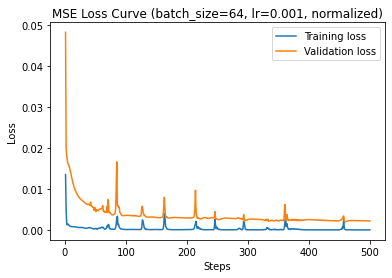

In [14]:
# Visualize training loss
updates = [i for i in range(1, len(loss_plot) + 1)]
plt.plot(updates, loss_plot, label="Training loss")
plt.plot(updates, val_loss_plot, label="Validation loss")
plt.title("MSE Loss Curve (batch_size=64, lr=0.001, normalized)")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Extrapolate

To fix: autoregressive extrapolation use our predicted price at t to predict t + 1. However, other values (volume, high, low, ...) are not predicted at point t, which force us to use label's values at point t in order to predict t + 1. This does not make much sense since these variables are highly correlated with each other.

Proposed fix 1

1, Train the model to predict the next 7 day in one go (Tuan)

2, Use close price to predict close price only (Thuy)

In [15]:
mv_net = MV_LSTM(n_features,n_timesteps)
mv_net.load_state_dict(torch.load('/content/mse_lstm_state_dict_model.pt'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mv_net.to(device)



preds = []
labels = []
losses = []
running_loss = 0

for i in range(len(X_test)):
  # start extrapolating from i
  X_test_copy = X_test.copy()
  y_test = y_test.copy()

  pred = []
  label = []
  if i + 30 > len(X_test):
    break 
  for j in range(i, i + 30):
    X_trapolate = X_test_copy[j:j+1,:,:]
    test_seq = y_test[j]
    # print(X_trapolate.shape)
    with torch.no_grad():
      inpt = X_trapolate
      # replace label with predicted value
      for k in range(len(pred)):
        # print(k, j)
        # print(pred)
        # print(X_trapolate[0][-k][3])
        X_trapolate[0][-k][3] = pred[k]
      #print(X_trapolate)
      target = test_seq  
      x_batch = (
          torch.from_numpy(inpt).float().to(device)
      ) 
      # y_batch = torch.from_numpy(
      #     target
      # ).float()  
      mv_net.init_hidden(x_batch.size(0))
      output = mv_net(x_batch)
      t = output.cpu().view(-1).numpy()[0]
      # Produce output of the extrapolation
      # print(t)
      pred.append(t)
      label.append(test_seq)
      # Update test seq

      # np_to_add = X_trapolate[i][0]
      # np_to_add[-1] = t
      # arr = test_seq.tolist()
      # del arr[0][0]
      # arr[0].append(np_to_add)
      # test_seq = np.array(arr)
    preds.append(pred)
    labels.append(label)
        

Streaming output truncated to the last 5000 lines.
0.62547064
0.6702099
0.6315754
0.62797976
0.6269375
0.6778532
0.6154393
0.62598884
0.6455857
0.65123856
0.65744126
0.6225383
0.63870996
0.65384674
0.5939709
0.6279223
0.5642186
0.6274772
0.6181169
0.5899004
0.6471756
0.64221734
0.6469508
0.63756734
0.59744906
0.61089295
0.61421984
0.6067771
0.6254277
0.62017465
0.66598004
0.62744737
0.62281734
0.6232905
0.67247957
0.60952425
0.61884975
0.63927025
0.6446632
0.65103626
0.6163869
0.63123006
0.64752686
0.58785367
0.62126327
0.55768746
0.62380624
0.61381495
0.5850022
0.6215798
0.64136475
0.6534412
0.64220935
0.60368365
0.61580384
0.6186029
0.6089258
0.6276147
0.6226126
0.6676771
0.6290753
0.62477684
0.6240362
0.6743091
0.61232483
0.6234241
0.6424045
0.6477343
0.65456516
0.6197021
0.6368034
0.65246755
0.59272027
0.62464345
0.5602474
0.6266527
0.61807275
0.5884809
0.6238753
0.6041968
0.6528488
0.64036095
0.59844244
0.61321425
0.61475307
0.6046277
0.6211828
0.6170732
0.6615785
0.62287056
0.618

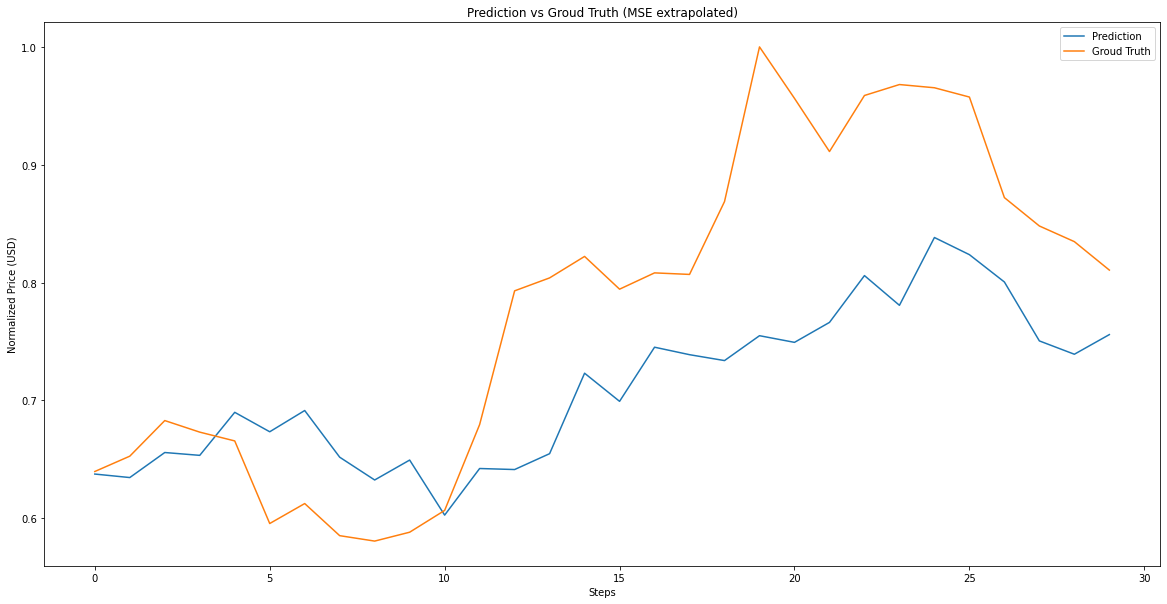

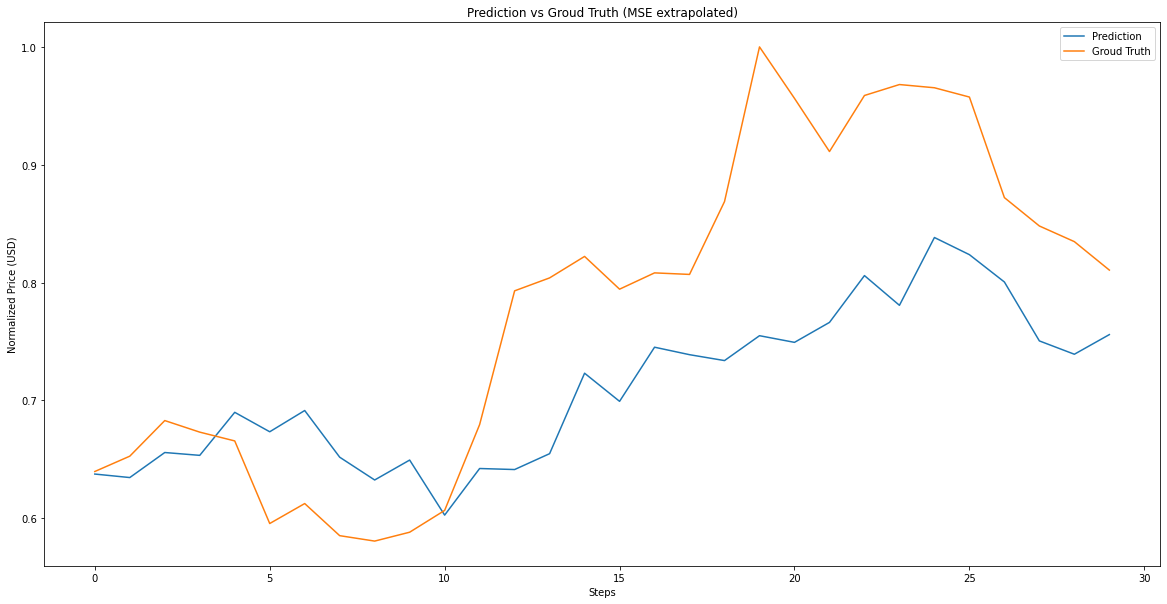

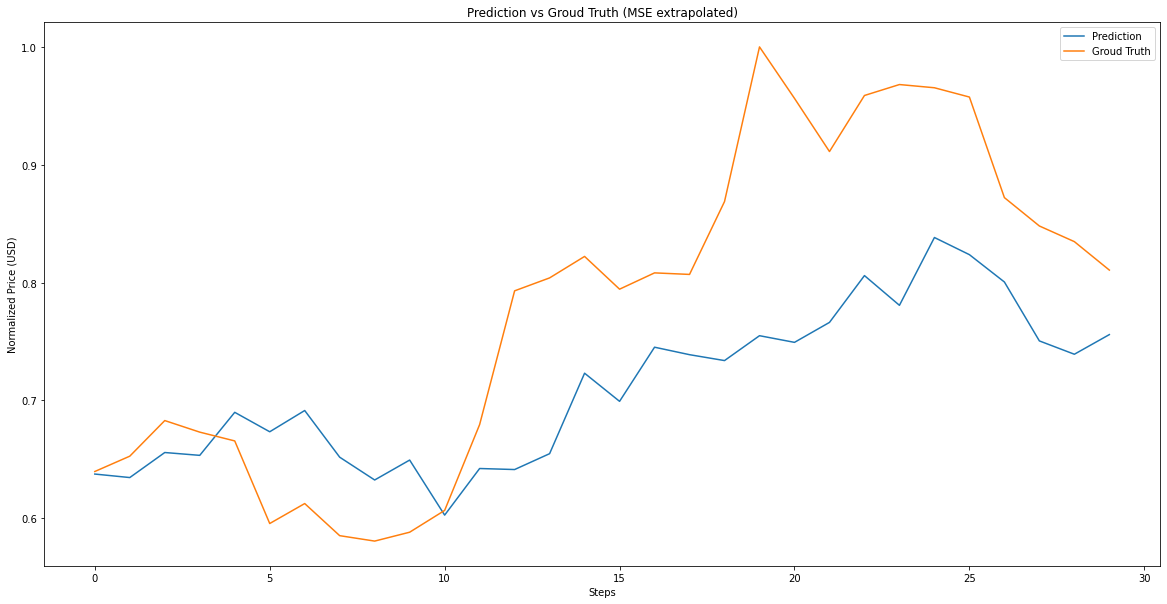

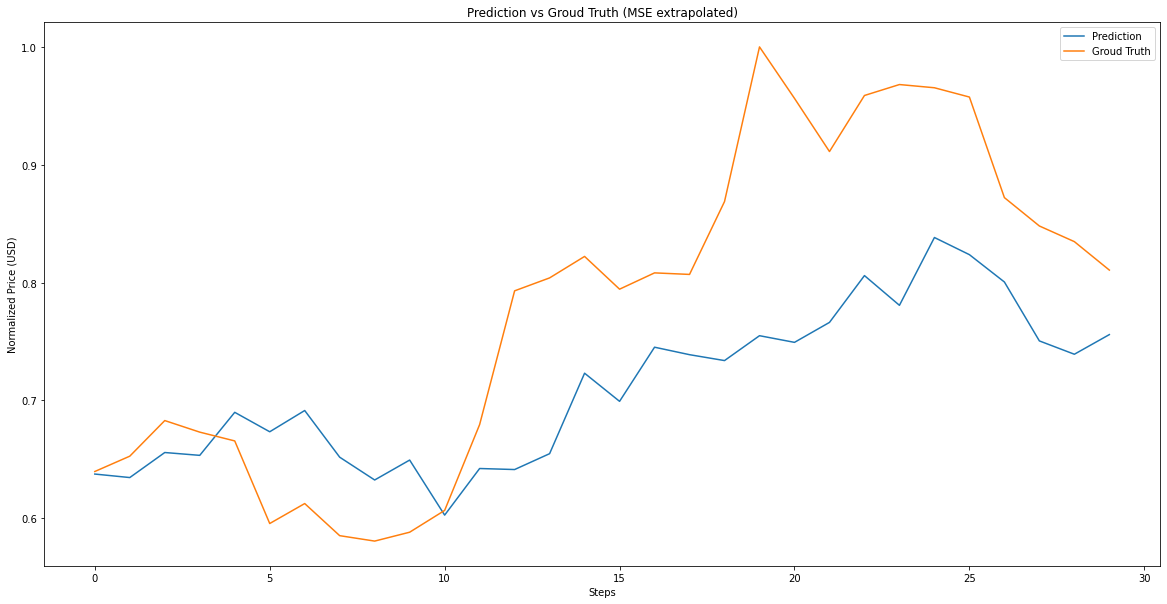

KeyboardInterrupt: ignored

In [17]:
# Visualize preds vs labels
for j in range(len(preds)):
  pred = preds[j]
  label = labels[j]
  updates = [i for i in range(len(pred))]
  plt.figure(figsize=(20, 10))
  plt.plot(updates, pred, label="Prediction")
  plt.plot(updates, label, label="Groud Truth")
  plt.title("Prediction vs Groud Truth (MSE extrapolated)")
  plt.xlabel("Steps")
  plt.ylabel("Normalized Price (USD)")
  plt.legend()
  plt.show()
  #plt.savefig('')